<img src='http://upload.wikimedia.org/wikipedia/commons/6/6e/St%C3%B6wer_Titanic.jpg'>


In [7]:
#Importing all the libraries needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import brewer2mpl
import seaborn as sns

In [8]:
# Setting up better defaults for matplotlib
from matplotlib import rcParams

rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18

#colorbrewer2 Dark2 qualitative color table
dark2_colors = brewer2mpl.get_map('Dark2', 'Qualitative', 7).mpl_colors

In [9]:
# Load data
df= pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')

## Explore Data

What values are missing and how many ?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 153.4+ KB


In [39]:
df.shape[0] - df.count()

pclass           0
survived         0
name             0
sex              0
age            263
sibsp            0
parch            0
ticket           0
fare             1
cabin         1014
embarked         2
boat           823
body          1188
home.dest      564
name_match       0
dtype: int64

[ 46  28 103  94  66  41  32  15   0   2]


<Container object of 10 artists>

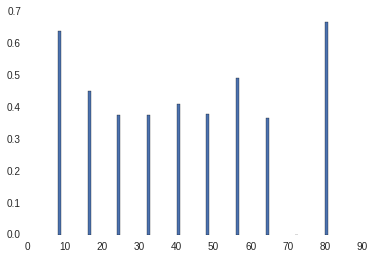

In [125]:
y, x = np.histogram(df[df['survived']==1]['age'].dropna())
tot, _ = np.histogram(df['age'].dropna())
tot = tot.astype(np.float32)
print y
Y = np.divide(y, tot)
plt.bar(x[1:],Y)

## NLP: Using the first and last names

My guess, is that in 1911 racial profiling was common and there was a severe racism as well as classism.
So my hypothsis, is that the first and last names will give insight into the ethnic background of the passengers.


In [38]:
print df.name[0]

Allen, Miss. Elisabeth Walton


In [13]:
first_name = map(lambda s:s.split(' ')[2], df.name)
last_name = map(lambda s:s.split(',')[0], df.name)

names = map(lambda tup:"%s %s" %(tup[0], tup[1]), zip(first_name, last_name))
names = np.array(names)
print names[0:10]

sur_name_ind = df[df.survived == 1].index.tolist()
sur_name = names[sur_name_ind]
sur_name[0:10]

['Elisabeth Allen' 'Hudson Allison' 'Helen Allison' 'Hudson Allison'
 'Hudson Allison' 'Harry Anderson' 'Kornelia Andrews' 'Thomas Andrews'
 'Edward Appleton' 'Ramon Artagaveytia']


array(['Elisabeth Allen', 'Hudson Allison', 'Harry Anderson',
       'Kornelia Andrews', 'Edward Appleton', 'John Astor',
       'Leontine Aubart', 'Ellen Barber', 'Algernon Barkworth',
       'James Baxter'], 
      dtype='|S32')

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(max_features=150,
                      decode_error='ignore',
                      strip_accents='unicode',
                      analyzer='char_wb',
                      ngram_range=(3,3)
                      )

vec.fit(sur_name)
name_vec = vec.transform(names)
name_vec = name_vec.toarray()
#name_fea = vec.get_feature_names()
out = vec.inverse_transform(name_vec)

In [15]:
count_sum = np.squeeze(name_vec.sum(axis=1))
print count_sum.shape

test = pd.DataFrame({'name':names, 'fea':out, 'count': count_sum, 'survived':df.survived})
test.fillna(0, inplace=True)

(1309,)


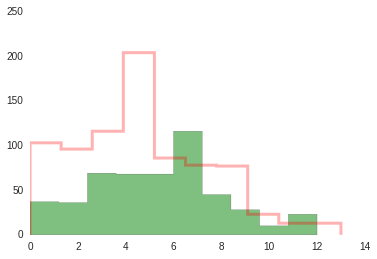

In [16]:
sur = test[test.survived == 1]
sur['count'].hist(histtype="stepfilled", alpha=0.5, color='g',bins=10)

died = test[test.survived == 0]
died['count'].hist(histtype="step", alpha=0.3, color='r', linewidth=3, bins=10)

In [17]:
df['name_match'] = test['count']

# Cleaning Data

##Missing Data: Age

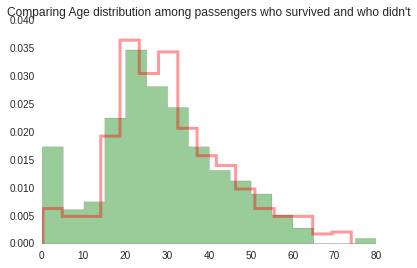

In [19]:
%matplotlib inline
# Let's first look at the distribution of age
df[df.survived==1].age.dropna().hist(histtype='stepfilled', color='green', alpha = 0.4, bins=16, normed=True)
df[df.survived==0].age.dropna().hist(histtype='step', color='red', linewidth=3, alpha=0.4, bins=16, normed=True)
plt.grid(axis = 'x', color ='white', linestyle='-')
plt.title("Comparing Age distribution among passengers who survived and who didn't")

A common approach to this type of situation is to replace with the average of the available values. In this case, that would mean replacing 177 missing Age values with 29.7.Taking such an approach would be fine if only a small fraction of the age values were missing. However, with missing values accounting for 20 percent of all age values in a relatively small data set (<900 records), it is better to search for a more refined method of imputation. 

In [14]:
df.name[:10]

0                      Allen, Miss. Elisabeth Walton
1                     Allison, Master. Hudson Trevor
2                       Allison, Miss. Helen Loraine
3               Allison, Mr. Hudson Joshua Creighton
4    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)
5                                Anderson, Mr. Harry
6                  Andrews, Miss. Kornelia Theodosia
7                             Andrews, Mr. Thomas Jr
8      Appleton, Mrs. Edward Dale (Charlotte Lamson)
9                            Artagaveytia, Mr. Ramon
Name: name, dtype: object

In [15]:
df.name.map(lambda x: x.split(','))[0][1].split('.')[0]

' Miss'

In [16]:
df['title'] = (df.name.map(lambda x: x.split(',')).map(lambda x: x[1].split('.')[0] ))

In [17]:
grouped = df.groupby(['pclass','title'])
grouped.mean()

survived        age     sibsp     parch        fare  \
pclass title                                                                
1       Capt          0.000000  70.000000  1.000000  1.000000   71.000000   
        Col           0.500000  54.000000  0.250000  0.000000   79.518750   
        Don           0.000000  40.000000  0.000000  0.000000   27.720800   
        Dona          1.000000  39.000000  0.000000  0.000000  108.900000   
        Dr            0.666667  45.600000  0.833333  0.166667   66.922917   
        Jonkheer      0.000000  38.000000  0.000000  0.000000    0.000000   
        Lady          1.000000  48.000000  1.000000  0.000000   39.600000   
        Major         0.500000  48.500000  0.000000  0.000000   28.525000   
        Master        1.000000   6.984000  0.800000  2.000000  150.056660   
        Miss          0.950000  30.338983  0.350000  0.516667  130.218958   
        Mlle          1.000000  24.000000  0.000000  0.000000   59.402100   
        Mme           1.000000  24.000000  0.000000  0.000000   69.300000   
        Mr            0.308176  41.450758  0.308176  0.238994   68.260090   
        Mrs           0.974026  43.208955  0.753247  0.480519   97.314448   
        Sir           1.000000  49.000000  1.000000  0.000000   56.929200   
        the Countess  1.000000  33.000000  0.000000  0.000000   86.500000   
2       Dr            0.000000  38.500000  0.000000  0.000000   12.250000   
        Master        1.000000   2.757273  0.818182  1.272727   27.386745   
        Miss          0.940000  20.717083  0.400000  0.640000   22.571500   
        Mr            0.093333  32.346715  0.300000  0.113333   19.527443   
        Mrs           0.836364  33.518519  0.600000  0.672727   24.023940   
        Ms            1.000000  28.000000  0.000000  0.000000   13.000000   
        Rev           0.000000  41.250000  0.250000  0.250000   18.609375   
3       Master        0.333333   6.090000  2.488889  1.333333   25.443609   
        Miss          0.480000  17.360874  0.880000  0.453333   14.375697   
        Mr            0.133929  28.318910  0.267857  0.147321   11.103904   
        Mrs           0.523077  32.326531  0.600000  1.384615   17.629743   
        Ms            0.000000        NaN  0.000000  0.000000    7.750000   

                            body  name_match  
pclass title                                  
1       Capt          269.000000    5.000000  
        Col           124.000000    3.500000  
        Don                  NaN    3.000000  
        Dona                 NaN    2.000000  
        Dr            230.000000    6.166667  
        Jonkheer             NaN    6.000000  
        Lady                 NaN    2.000000  
        Major                NaN    3.000000  
        Master               NaN    7.600000  
        Miss                 NaN    5.533333  
        Mlle                 NaN    4.000000  
        Mme                  NaN    5.000000  
        Mr            158.625000    5.836478  
        Mrs                  NaN    6.220779  
        Sir                  NaN    2.000000  
        the Countess         NaN    3.000000  
2       Dr                   NaN    3.500000  
        Master               NaN    5.727273  
        Miss                 NaN    4.240000  
        Mr            171.137931    5.113333  
        Mrs            52.000000    5.690909  
        Ms                   NaN    2.000000  
        Rev           174.000000    6.000000  
3       Master         24.000000    4.511111  
        Miss          229.333333    4.840000  
        Mr            160.377778    4.236607  
        Mrs           148.250000    4.630769  
        Ms                   NaN    2.000000

In [18]:
#f = lambda x: x.fillna(x.std() * np.random.randn() + x.mean())
f = lambda x: x.fillna(x.mean())
transformed = grouped.transform(f)
transformed.tail()

,survived,age,sibsp,parch,fare,body,name_match
1304,0,14.500000,1,0,14.4542,328.000000,1
1305,0,17.360874,1,0,14.4542,229.333333,5
1306,0,26.500000,0,0,7.2250,304.000000,7
1307,0,27.000000,0,0,7.2250,160.377778,3
1308,0,29.000000,0,0,7.8750,160.377778,3


In [19]:
df.tail()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,name_match,title
1304,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,NaN,328,NaN,1,Miss
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN,5,Miss
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,NaN,304,NaN,7,Mr
1307,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN,3,Mr
1308,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S,NaN,NaN,NaN,3,Mr


In [20]:
df.age = transformed.age
df[ df['age'].isnull() ]  [['pclass','age']].head()

,pclass,age
1076,3,NaN


##Missing Values:Cabin

In [138]:
df["deck"] = df.cabin.str[0]
df['deck'].fillna("U", inplace=True)
df.deck.value_counts()
df.groupby(["pclass", "deck"])["deck"].count()

pclass  deck
1       A        22
        B        65
        C        94
        D        40
        E        34
        T         1
        U        67
2       D         6
        E         4
        F        13
        U       254
3       E         3
        F         8
        G         5
        U       693
Name: deck, dtype: int64

##Data Value Validation:Fare
>While there are no missing Fare values, a summary does show at least one Fare=0

In [22]:
df[df['fare'] < 5] 

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,name_match,title,deck
7,1,0,"Andrews, Mr. Thomas Jr",male,39.000000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI",8,Mr,A
70,1,0,"Chisholm, Mr. Roderick Robert Crispin",male,41.450758,0,0,112051,0.0000,NaN,S,NaN,NaN,"Liverpool, England / Belfast",7,Mr,U
125,1,0,"Fry, Mr. Richard",male,41.450758,0,0,112058,0.0000,B102,S,NaN,NaN,NaN,8,Mr,B
150,1,0,"Harrison, Mr. William",male,40.000000,0,0,112059,0.0000,B94,S,NaN,110,NaN,12,Mr,B
170,1,1,"Ismay, Mr. Joseph Bruce",male,49.000000,0,0,112058,0.0000,B52 B54 B56,S,C,NaN,Liverpool,1,Mr,B
223,1,0,"Parr, Mr. William Henry Marsh",male,41.450758,0,0,112052,0.0000,NaN,S,NaN,NaN,Belfast,8,Mr,U
234,1,0,"Reuchlin, Jonkheer. John George",male,38.000000,0,0,19972,0.0000,NaN,S,NaN,NaN,"Rotterdam, Netherlands",6,Jonkheer,U
363,2,0,"Campbell, Mr. William",male,32.346715,0,0,239853,0.0000,NaN,S,NaN,NaN,Belfast,10,Mr,U
384,2,0,"Cunningham, Mr. Alfred Fleming",male,32.346715,0,0,239853,0.0000,NaN,S,NaN,NaN,Belfast,6,Mr,U
410,2,0,"Frost, Mr. Anthony Wood ""Archie""",male,32.346715,0,0,239854,0.0000,NaN,S,NaN,NaN,Belfast,4,Mr,U


In [23]:
# first we set those fares of 0 to nan
df.fare = df.fare.map(lambda x: np.nan if x==0 else x)

# calculate the mean fare for each class
class_mean = df.pivot_table('fare', index='pclass', aggfunc='mean')

# replace fare with mean fare for class where fare value was zero
df.fare = df[['fare', 'pclass']].apply(lambda x: class_mean[x['pclass']] if pd.isnull(x['fare']) else x['fare'], axis=1 )


/home/daniel/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/index.py:667: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point
  type(self).__name__),FutureWarning)


###Creating a new column: fare_per_passenger

> when we were investigating 'cabin' we found out that ticket price included group price, we will be better off creating a new variable representative of price per person

In [24]:
df.pclass.value_counts()

3    709
1    323
2    277
dtype: int64

In [25]:
df['family_size'] = df['sibsp'] + df['parch']
df['fare_per_p'] = df['fare'] / (df['family_size'] + 1)

In [26]:
df[['fare','fare_per_p']].describe()

,fare,fare_per_p
count,1309.000000,1309.000000
mean,33.898702,21.131198
std,51.779841,36.036161
min,3.170800,1.110714
25%,7.925000,7.650000
50%,14.500000,8.662500
75%,31.387500,25.929200
max,512.329200,512.329200


##Missing Values: Embarked

In [27]:
from scipy.stats import mode

mode_embarked = mode(df['embarked'])[0][0]
df['embarked'] = df['embarked'].fillna(mode_embarked)

/home/daniel/anaconda/envs/py27/lib/python2.7/site-packages/numpy/lib/arraysetops.py:198: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


#Derived variables

In [28]:
df['age*Class'] = (df.age) / (df.pclass)

#Exploratory Data Visualization

Let's look at overall distribution of the cleaned data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bb9caf310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8bb9744f90>]], dtype=object)

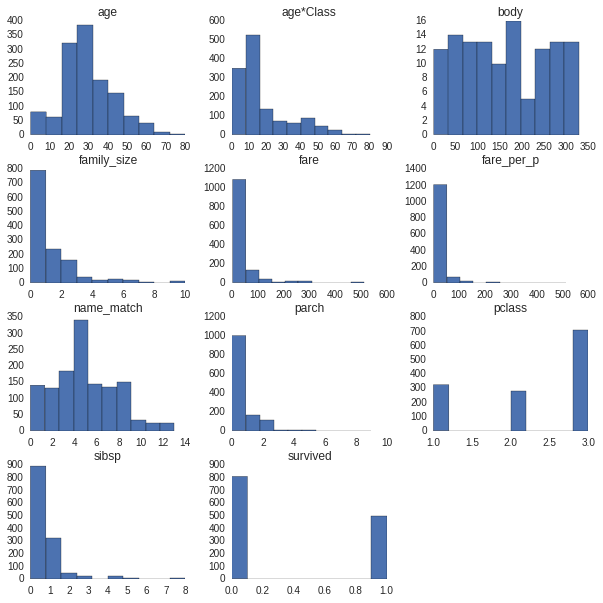

In [29]:
df.hist(figsize=(10,10))

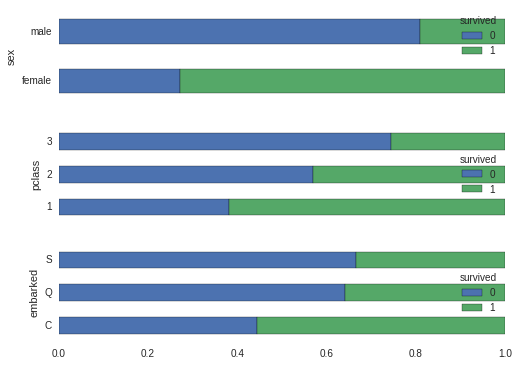

In [30]:
# code in this namespace is adapted from https://triangleinequality.wordpress.com/2013/05/25/plotting-with-python/

def proportionSurvived(discreteVar):
    by_var = df.groupby([discreteVar,'survived'])
    table = by_var.size().unstack()
    normedtable = table.div(table.sum(1), axis=0)
    return normedtable

discreteVarList = ['sex', 'pclass', 'embarked']

fig1, axes1 = plt.subplots(len(discreteVarList),1,figsize=(8,6))

for i in range(len(discreteVarList)):
    var = discreteVarList[i]
    table = proportionSurvived(var)
    table.plot(kind='barh', stacked=True, ax=axes1[i])


#Preparing Data for Machine Learning

In [31]:
df.dtypes
#df.dtypes[df.dtypes.map(lambda x: x=='object')]

pclass           int64
survived         int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
boat            object
body           float64
home.dest       object
name_match       int64
title           object
deck            object
family_size      int64
fare_per_p     float64
age*Class      float64
dtype: object

##Dummy Variables: Embarked, Deck, Gender

In [32]:
pd.get_dummies(df['embarked'], prefix='embarked').head(10)

,embarked_C,embarked_Q,embarked_S
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


In [33]:
df = pd.concat([df, pd.get_dummies(df['embarked'], prefix='embarked')], axis=1)

###Deck

In [34]:
df = pd.concat([df, pd.get_dummies(df['deck'], prefix='deck')], axis=1)

###Gender

In [35]:
df['gender'] = df['sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [36]:
df = df.drop(['name', 'deck', 'sex','ticket','fare','embarked','cabin','boat','body','home.dest','title'], axis=1) 
df = df.dropna()

In [37]:
df.columns

Index([u'pclass', u'survived', u'age', u'sibsp', u'parch', u'name_match', u'family_size', u'fare_per_p', u'age*Class', u'embarked_C', u'embarked_Q', u'embarked_S', u'deck_A', u'deck_B', u'deck_C', u'deck_D', u'deck_E', u'deck_F', u'deck_G', u'deck_T', u'deck_U', u'gender'], dtype='object')

## Data as needed by Sklearn

In [38]:
# place column to be predicted(survived) in a different dataframe for sklearn
y = df['survived']
X = df.drop(['survived'],axis=1)

In [39]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=12)
y = np.ravel(y)

# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn import metrics
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

In [98]:
# https://www.kaggle.com/c/titanic/prospector#1254
# https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#ooberr

oob = []
test = []
for i in range(1,26, 2):
    clf = RandomForestClassifier(n_estimators=1000, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=i, 
                                min_samples_leaf=5, 
                                min_weight_fraction_leaf=0.0, 
                                max_features=None, 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0,
                                class_weight="subsample"
                                   )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    oob.append(clf.oob_score_)
    test.append(metrics.accuracy_score(y_test, y_pred))

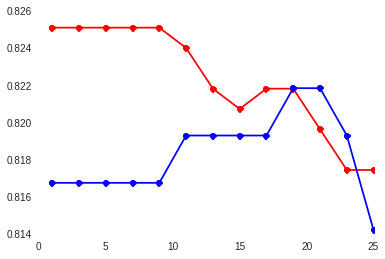

In [99]:
x = np.arange(1, 26, 2)
plt.plot(x, oob, '-ro')
plt.plot(x, test, '-bo')

In [100]:
clf = RandomForestClassifier(n_estimators=1000, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=19, 
                                min_samples_leaf=5, 
                                min_weight_fraction_leaf=0.0, 
                                max_features=None, 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0,
                                class_weight="subsample"
                                   )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
oob = clf.oob_score_
print oob, metrics.accuracy_score(y_test, y_pred)

0.821857923497 0.821882951654


In [101]:
def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y_test).mean()
    return cm


print "Accuracy:", metrics.accuracy_score(y_test, y_pred)
#print "\nClassification report:\n", metrics.classification_report(y_test, y_pred)
print "\nConfusion matrix:\n\n", confusion_matrix(y_test, y_pred)

Accuracy: 0.821882951654

Confusion matrix:

Predicted label    0    1
True label               
0                212   28
1                 42  111


In [102]:
#Below code to perform feature importance is adapted from 
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)

importances = forest.feature_importances_

In [103]:
print importances

[ 0.04703749  0.13557584  0.02872723  0.02308245  0.11678856  0.04556952
  0.15929757  0.13866454  0.0160744   0.00670297  0.01459192  0.00459641
  0.00499706  0.00573026  0.00423557  0.00954189  0.00310043  0.00076407
  0.00024126  0.03103949  0.20364107]


In [104]:
fea_names = list(X.columns)

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking in the order of importance(1 being higher):\n")

for f in range(len(fea_names)):
    print("(%d)'%s' - %f" % (f + 1, fea_names[indices[f]], 
          importances[indices[f]]))
    

Feature ranking in the order of importance(1 being higher):

(1)'gender' - 0.203641
(2)'fare_per_p' - 0.159298
(3)'age*Class' - 0.138665
(4)'age' - 0.135576
(5)'name_match' - 0.116789
(6)'pclass' - 0.047037
(7)'family_size' - 0.045570
(8)'deck_U' - 0.031039
(9)'sibsp' - 0.028727
(10)'parch' - 0.023082
(11)'embarked_C' - 0.016074
(12)'embarked_S' - 0.014592
(13)'deck_E' - 0.009542
(14)'embarked_Q' - 0.006703
(15)'deck_C' - 0.005730
(16)'deck_B' - 0.004997
(17)'deck_A' - 0.004596
(18)'deck_D' - 0.004236
(19)'deck_F' - 0.003100
(20)'deck_G' - 0.000764
(21)'deck_T' - 0.000241


In [105]:
from sklearn.ensemble import GradientBoostingClassifier

# Model and test.
clf = GradientBoostingClassifier(learning_rate=0.01,max_depth=8,n_estimators=50).fit(X_train, y_train)

prob = clf.predict_proba(X_test)[:,1]   # Only look at P(y==1).

fpr, tpr, thresholds = roc_curve(y_test, prob)
roc_auc_prob = auc(fpr, tpr)

#print(prob)
#print(y_test)
print(roc_auc_prob)

0.833224400871
